# TFRS - Tuning Retrieval (The Two Towers Model)

![logo_small](https://user-images.githubusercontent.com/67468718/127299425-533f0a3c-c965-42a5-886a-5272170d9e0e.JPG)



## Contents:

 1. Run baseline First Stage: Retrieval 
 2. Increase embedding_dimension from 32 to 64
 3. Reduce Adagrad learning_rate:
  * 0.01
  * 0.001 (Default)  
 4. epochs = 32 
 5. Tuning Summary


## Importing 



In [25]:
# Import the necessary Libararies: 

import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

### Preparing the dataset


In [3]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)
# Features of all the available movies.
movies = tfds.load("movielens/1m-movies", split="train", shuffle_files=True)

In [4]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 25.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'1203',
 'movie_title': b'12 Angry Men (1957)',
 'timestamp': 1015736614,
 'user_gender': True,
 'user_id': b'3475',
 'user_occupation_label': 14,
 'user_occupation_text': b'sales/marketing',
 'user_rating': 3.0,
 'user_zip_code': b'33133'}


In [5]:
#The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels:
#View the data from movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([5, 7], dtype=int64),
 'movie_id': b'1729',
 'movie_title': b'Jackie Brown (1997)'}


In [6]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_title": x["movie_title"],
                                 "user_id": x["user_id"],
                                })

movies = movies.map(lambda x: x["movie_title"])

In [7]:
len(ratings)

1000209

In [8]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [9]:
# Now, let's find out how many uniques users/movies:
movie_titles = movies.batch(l)
user_ids = ratings.batch(l).map(lambda x: x["user_id"])

#Movies uniques:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

#users unique
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# take a look at the movies:
unique_movie_titles[:10]

array([b'$1,000,000 Duck (1971)', b"'Night Mother (1986)",
       b"'Til There Was You (1997)", b"'burbs, The (1989)",
       b'...And Justice for All (1979)', b'1-900 (1994)',
       b'10 Things I Hate About You (1999)', b'101 Dalmatians (1961)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)'], dtype=object)

In [10]:
#Movies uniques
len_films = len(unique_movie_titles)
print(len_films) 

3883


In [11]:
#users unique
len_users = len(unique_user_ids)
print(len_users) 

6040


## 1. Run baseline First Stage: Retrieval 


In [12]:
#Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
embedding_dimension = 32

In [13]:
#We define the embedding on the user side, we must transform the user ids into a vector representation:
#we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer:
user_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  #User_ids vocabulary: list of unique integers that represents each user_id
                                  vocabulary=unique_user_ids, mask_token=None),
                                  # We add an additional embedding to account for unknown tokens.
                                  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
                                  embedding_dimension)#embedding layer with a vector size of 32
                                ])


# So, basically we want an embedding layer for however many user ids we have where each one is represented by a vector of 64 floating point values that 
# basically represents in that 64-dimensional space how similar users 


In [14]:
# We now define the embedding of the movie portion 
movie_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  vocabulary=unique_movie_titles, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_movie_titles) + 1,
                                  embedding_dimension) #embedding layer with a vector size of 32
                                 ])

In [15]:
#We define the desired metrics : FactorizedTopK
metrics = tfrs.metrics.FactorizedTopK(
                                     candidates=movies.batch(128).map(movie_model)
                                     )

In [16]:
#The Retrieval task is defined according to the FactorizedTopK metrics:
task = tfrs.tasks.Retrieval(
                            metrics=metrics
                           )

In [17]:
class MovielensModel(tfrs.Model):
    
    def __init__(self, user_model, movie_model):
        super().__init__()
        #The Two Towers: Movie and user Models:
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

In [18]:
class NoBaseClassMovielensModel(tf.keras.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

In [19]:
#Let's first instantiate the model.
model = MovielensModel(user_model, movie_model)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) # learning_rate default=0.001

In [20]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [21]:
# Then, let's train the model:
history_train = model.fit(cached_train, validation_data = cached_test, epochs=5)

Epoch 1/5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


92/92 [==============================] - 365s 4s/step - factorized_top_k/top_1_categorical_accuracy: 7.3451e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0071 - factorized_top_k/top_10_categorical_accuracy: 0.0154 - factorized_top_k/top_50_categorical_accuracy: 0.0740 - factorized_top_k/top_100_categorical_accuracy: 0.1335 - loss: 71287.2204 - regularization_loss: 0.0000e+00 - total_loss: 71287.2204 - val_factorized_top_k/top_1_categorical_accuracy: 0.0022 - val_factorized_top_k/top_5_categorical_accuracy: 0.0145 - val_factorized_top_k/top_10_categorical_accuracy: 0.0279 - val_factorized_top_k/top_50_categorical_accuracy: 0.1127 - val_factorized_top_k/top_100_categorical_accuracy: 0.1913 - val_loss: 945.6526 - val_regularization_loss: 0.0000e+00 - val_total_loss: 945.6526
Epoch 2/5
92/92 [==============================] - 248s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0125 - factorized_top_k/top_10_categorical_

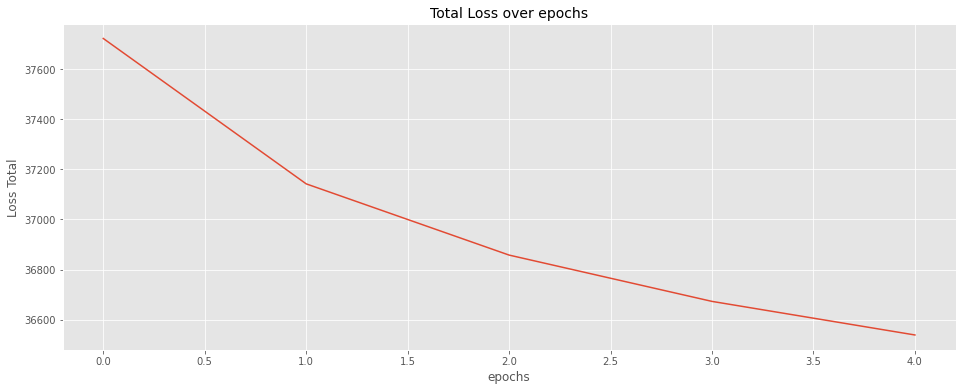

In [22]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


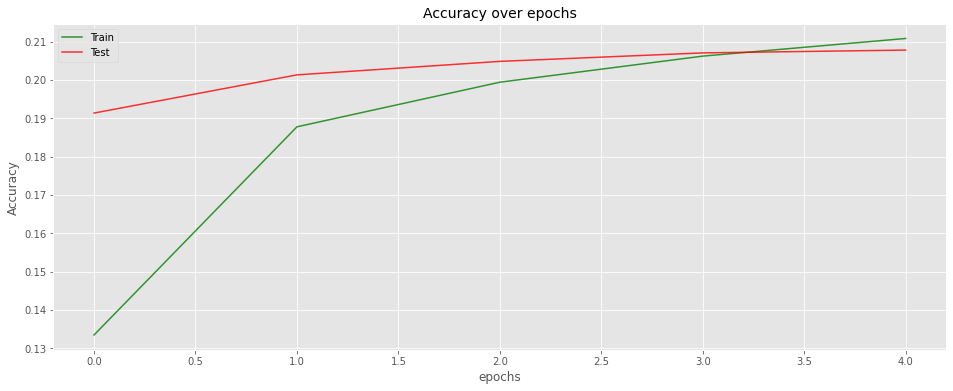

In [23]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [24]:
#Evaluate the Base model
model.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 55s 451ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0167 - factorized_top_k/top_10_categorical_accuracy: 0.0324 - factorized_top_k/top_50_categorical_accuracy: 0.1254 - factorized_top_k/top_100_categorical_accuracy: 0.2078 - loss: 14020.2831 - regularization_loss: 0.0000e+00 - total_loss: 14020.2831


{'factorized_top_k/top_1_categorical_accuracy': 0.002739430172368884,
 'factorized_top_k/top_5_categorical_accuracy': 0.016660533845424652,
 'factorized_top_k/top_10_categorical_accuracy': 0.032353270798921585,
 'factorized_top_k/top_50_categorical_accuracy': 0.1253899186849594,
 'factorized_top_k/top_100_categorical_accuracy': 0.20778077840805054,
 'loss': 903.5606079101562,
 'regularization_loss': 0,
 'total_loss': 903.5606079101562}

## 2. Increase embedding_dimension from 32 to 64

In [27]:
#Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
embedding_dimension = 64

In [28]:
#We define the embedding on the user side, we must transform the user ids into a vector representation:
#we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer:
user_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  #User_ids vocabulary: list of unique integers that represents each user_id
                                  vocabulary=unique_user_ids, mask_token=None),
                                  # We add an additional embedding to account for unknown tokens.
                                  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
                                  embedding_dimension)#embedding layer with a vector size of 64
                                ])


# So, basically we want an embedding layer for however many user ids we have where each one is represented by a vector of 64 floating point values that 
# basically represents in that 64-dimensional space how similar users 


In [29]:
# We now define the embedding of the movie portion 
movie_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  vocabulary=unique_movie_titles, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_movie_titles) + 1,
                                  embedding_dimension) #embedding layer with a vector size of 64
                                 ])

In [30]:
#We define the desired metrics : FactorizedTopK
metrics = tfrs.metrics.FactorizedTopK(
                                     candidates=movies.batch(128).map(movie_model)
                                     )

In [31]:
#The Retrieval task is defined according to the FactorizedTopK metrics:
task = tfrs.tasks.Retrieval(
                            metrics=metrics
                           )

In [32]:
#Let's first instantiate the model.
model_1 = MovielensModel(user_model, movie_model)

model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) # learning_rate default=0.001

In [33]:
# Then, let's train the model:
history_train_1 = model_1.fit(cached_train, validation_data = cached_test, epochs=5)

Epoch 1/5
92/92 [==============================] - 200s 2s/step - factorized_top_k/top_1_categorical_accuracy: 5.2656e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0062 - factorized_top_k/top_10_categorical_accuracy: 0.0140 - factorized_top_k/top_50_categorical_accuracy: 0.0718 - factorized_top_k/top_100_categorical_accuracy: 0.1316 - loss: 71066.9152 - regularization_loss: 0.0000e+00 - total_loss: 71066.9152 - val_factorized_top_k/top_1_categorical_accuracy: 0.0023 - val_factorized_top_k/top_5_categorical_accuracy: 0.0159 - val_factorized_top_k/top_10_categorical_accuracy: 0.0308 - val_factorized_top_k/top_50_categorical_accuracy: 0.1190 - val_factorized_top_k/top_100_categorical_accuracy: 0.1998 - val_loss: 933.7153 - val_regularization_loss: 0.0000e+00 - val_total_loss: 933.7153
Epoch 2/5
92/92 [==============================] - 291s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0130 - factorized_top_k/top_10_ca

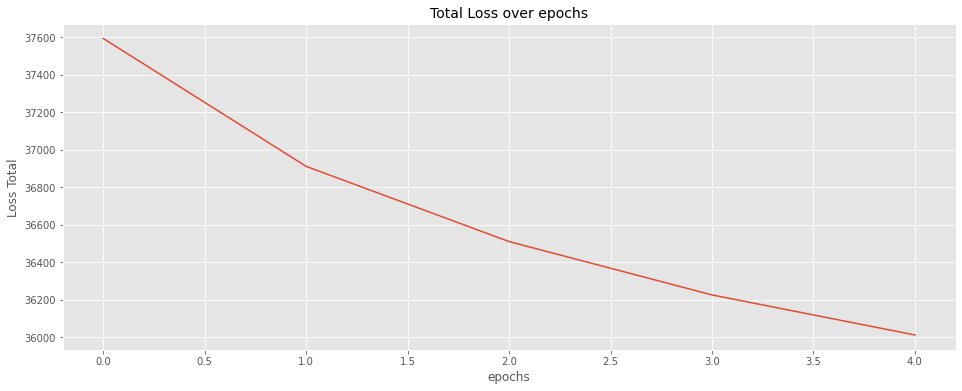

In [36]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


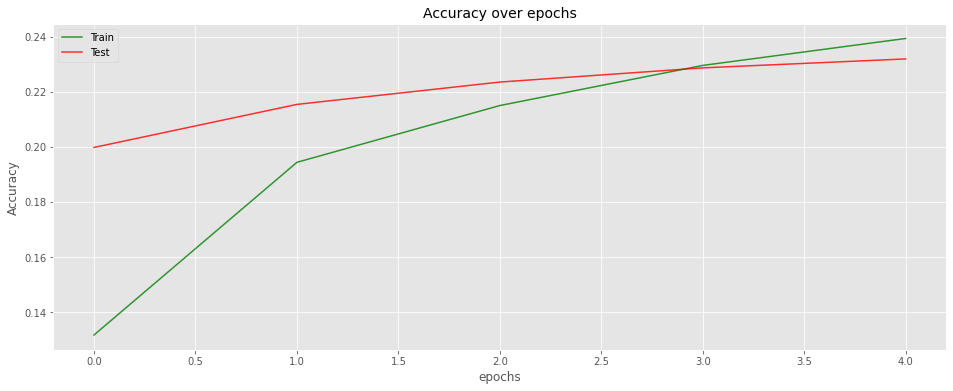

In [37]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_1.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [38]:
#Evaluate the Base model
model_1.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 30s 243ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 0.0207 - factorized_top_k/top_10_categorical_accuracy: 0.0396 - factorized_top_k/top_50_categorical_accuracy: 0.1431 - factorized_top_k/top_100_categorical_accuracy: 0.2320 - loss: 13800.7586 - regularization_loss: 0.0000e+00 - total_loss: 13800.7586


{'factorized_top_k/top_1_categorical_accuracy': 0.0029993760399520397,
 'factorized_top_k/top_5_categorical_accuracy': 0.020739685744047165,
 'factorized_top_k/top_10_categorical_accuracy': 0.039571769535541534,
 'factorized_top_k/top_50_categorical_accuracy': 0.14307823777198792,
 'factorized_top_k/top_100_categorical_accuracy': 0.2319837510585785,
 'loss': 874.5198364257812,
 'regularization_loss': 0,
 'total_loss': 874.5198364257812}

## 3. Reduce Adagrad learning_rate:

### 3.1 learning_rate = 0.01



In [39]:
#Let's first instantiate the model.
model_2 = MovielensModel(user_model, movie_model)

model_2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01)) # learning_rate default=0.001

In [40]:
# Then, let's train the model:
history_train_2 = model_2.fit(cached_train, validation_data = cached_test, epochs=5)

Epoch 1/5
92/92 [==============================] - 204s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0229 - factorized_top_k/top_10_categorical_accuracy: 0.0449 - factorized_top_k/top_50_categorical_accuracy: 0.1618 - factorized_top_k/top_100_categorical_accuracy: 0.2573 - loss: 65954.8439 - regularization_loss: 0.0000e+00 - total_loss: 65954.8439 - val_factorized_top_k/top_1_categorical_accuracy: 0.0029 - val_factorized_top_k/top_5_categorical_accuracy: 0.0210 - val_factorized_top_k/top_10_categorical_accuracy: 0.0401 - val_factorized_top_k/top_50_categorical_accuracy: 0.1447 - val_factorized_top_k/top_100_categorical_accuracy: 0.2343 - val_loss: 870.8970 - val_regularization_loss: 0.0000e+00 - val_total_loss: 870.8970
Epoch 2/5
92/92 [==============================] - 299s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0244 - factorized_top_k/top_10_catego

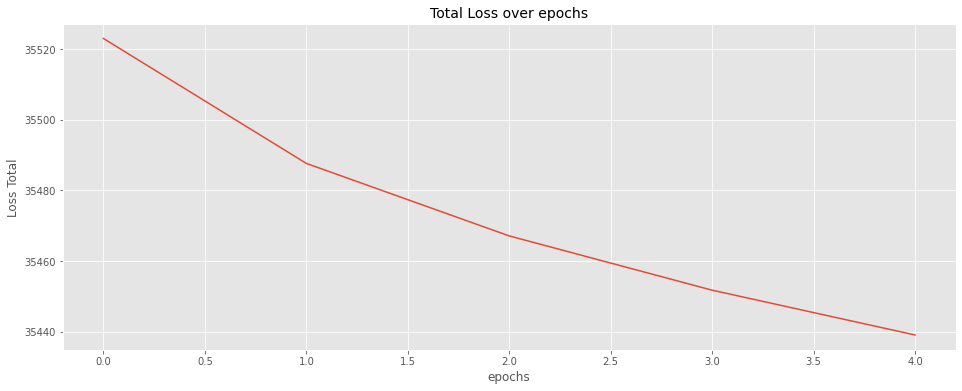

In [41]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


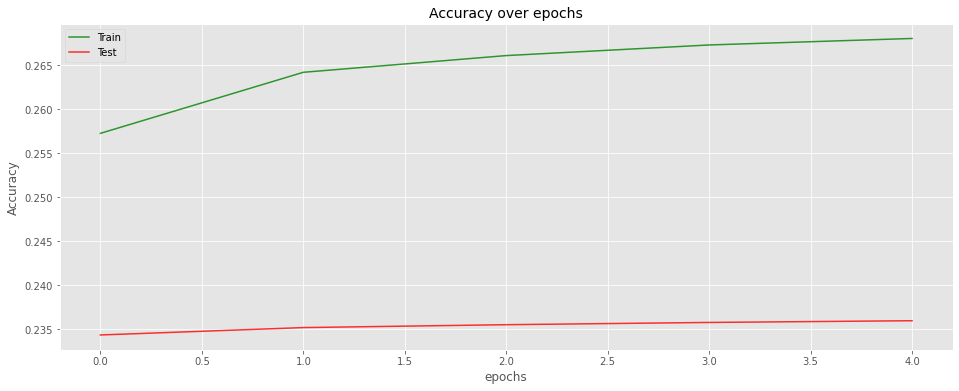

In [42]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_2.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [43]:
#Evaluate the Base model
model_2.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 68s 552ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0212 - factorized_top_k/top_10_categorical_accuracy: 0.0405 - factorized_top_k/top_50_categorical_accuracy: 0.1459 - factorized_top_k/top_100_categorical_accuracy: 0.2360 - loss: 13764.2400 - regularization_loss: 0.0000e+00 - total_loss: 13764.2400


{'factorized_top_k/top_1_categorical_accuracy': 0.0030953562818467617,
 'factorized_top_k/top_5_categorical_accuracy': 0.021155599504709244,
 'factorized_top_k/top_10_categorical_accuracy': 0.04047558084130287,
 'factorized_top_k/top_50_categorical_accuracy': 0.1459016501903534,
 'factorized_top_k/top_100_categorical_accuracy': 0.23596692085266113,
 'loss': 868.0618896484375,
 'regularization_loss': 0,
 'total_loss': 868.0618896484375}

### 3.2 learning_rate = 0.001 (Default)

In [44]:
#Let's first instantiate the model.
model_3 = MovielensModel(user_model, movie_model)

model_3.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001)) # learning_rate default=0.001

In [45]:
# Then, let's train the model:
history_train_3 = model_3.fit(cached_train, validation_data = cached_test, epochs=5)

Epoch 1/5
92/92 [==============================] - 263s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0254 - factorized_top_k/top_10_categorical_accuracy: 0.0491 - factorized_top_k/top_50_categorical_accuracy: 0.1716 - factorized_top_k/top_100_categorical_accuracy: 0.2696 - loss: 65560.5683 - regularization_loss: 0.0000e+00 - total_loss: 65560.5683 - val_factorized_top_k/top_1_categorical_accuracy: 0.0030 - val_factorized_top_k/top_5_categorical_accuracy: 0.0212 - val_factorized_top_k/top_10_categorical_accuracy: 0.0404 - val_factorized_top_k/top_50_categorical_accuracy: 0.1460 - val_factorized_top_k/top_100_categorical_accuracy: 0.2362 - val_loss: 867.7344 - val_regularization_loss: 0.0000e+00 - val_total_loss: 867.7344
Epoch 2/5
92/92 [==============================] - 309s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0256 - factorized_top_k/top_10_catego

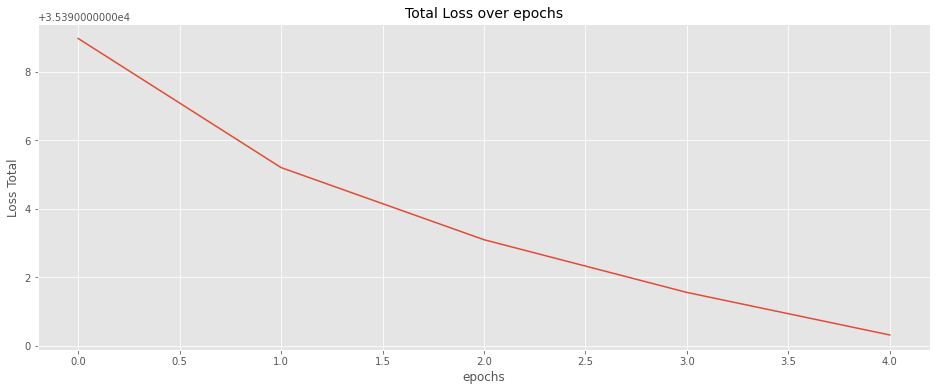

In [46]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_3.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


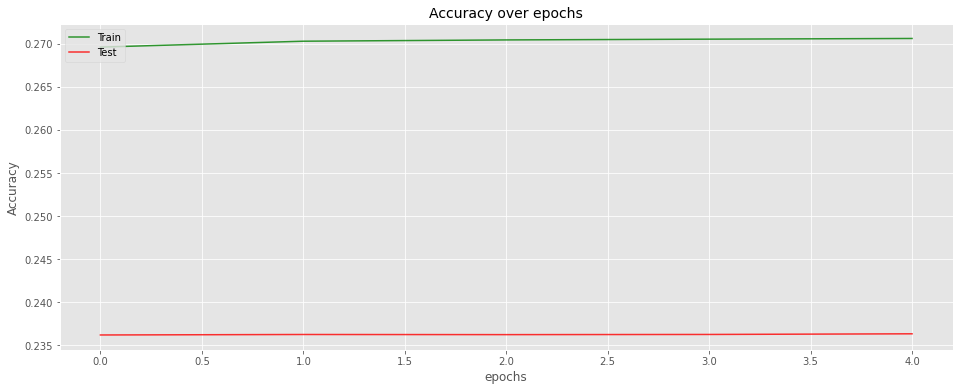

In [47]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_3.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_3.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [48]:
#Evaluate the Base model
model_3.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 34s 276ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 0.0212 - factorized_top_k/top_10_categorical_accuracy: 0.0405 - factorized_top_k/top_50_categorical_accuracy: 0.1460 - factorized_top_k/top_100_categorical_accuracy: 0.2363 - loss: 13761.6454 - regularization_loss: 0.0000e+00 - total_loss: 13761.6454


{'factorized_top_k/top_1_categorical_accuracy': 0.002995376940816641,
 'factorized_top_k/top_5_categorical_accuracy': 0.02123158425092697,
 'factorized_top_k/top_10_categorical_accuracy': 0.04049157723784447,
 'factorized_top_k/top_50_categorical_accuracy': 0.14596964418888092,
 'factorized_top_k/top_100_categorical_accuracy': 0.23634684085845947,
 'loss': 867.466552734375,
 'regularization_loss': 0,
 'total_loss': 867.466552734375}

## 4. epochs = 32

In [55]:
#Let's first instantiate the model.
model_4 = MovielensModel(user_model, movie_model)

model_4.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) # learning_rate default=0.001

In [56]:
# Then, let's train the model:
history_train_4 = model_4.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
92/92 [==============================] - 168s 2s/step - factorized_top_k/top_1_categorical_accuracy: 8.4516e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0116 - factorized_top_k/top_10_categorical_accuracy: 0.0258 - factorized_top_k/top_50_categorical_accuracy: 0.1209 - factorized_top_k/top_100_categorical_accuracy: 0.2097 - loss: 67132.7248 - regularization_loss: 0.0000e+00 - total_loss: 67132.7248 - val_factorized_top_k/top_1_categorical_accuracy: 0.0029 - val_factorized_top_k/top_5_categorical_accuracy: 0.0198 - val_factorized_top_k/top_10_categorical_accuracy: 0.0377 - val_factorized_top_k/top_50_categorical_accuracy: 0.1405 - val_factorized_top_k/top_100_categorical_accuracy: 0.2302 - val_loss: 855.1429 - val_regularization_loss: 0.0000e+00 - val_total_loss: 855.1429
Epoch 2/32
92/92 [==============================] - 226s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0174 - factorized_top_k/top_10_

92/92 [==============================] - 250s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0230 - factorized_top_k/top_10_categorical_accuracy: 0.0462 - factorized_top_k/top_50_categorical_accuracy: 0.1771 - factorized_top_k/top_100_categorical_accuracy: 0.2832 - loss: 64589.8073 - regularization_loss: 0.0000e+00 - total_loss: 64589.8073 - val_factorized_top_k/top_1_categorical_accuracy: 0.0033 - val_factorized_top_k/top_5_categorical_accuracy: 0.0214 - val_factorized_top_k/top_10_categorical_accuracy: 0.0409 - val_factorized_top_k/top_50_categorical_accuracy: 0.1526 - val_factorized_top_k/top_100_categorical_accuracy: 0.2488 - val_loss: 845.8887 - val_regularization_loss: 0.0000e+00 - val_total_loss: 845.8887
Epoch 12/32
92/92 [==============================] - 256s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0232 - factorized_top_k/top_10_categorical_ac

92/92 [==============================] - 258s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0246 - factorized_top_k/top_10_categorical_accuracy: 0.0493 - factorized_top_k/top_50_categorical_accuracy: 0.1862 - factorized_top_k/top_100_categorical_accuracy: 0.2950 - loss: 64260.1349 - regularization_loss: 0.0000e+00 - total_loss: 64260.1349 - val_factorized_top_k/top_1_categorical_accuracy: 0.0032 - val_factorized_top_k/top_5_categorical_accuracy: 0.0220 - val_factorized_top_k/top_10_categorical_accuracy: 0.0424 - val_factorized_top_k/top_50_categorical_accuracy: 0.1568 - val_factorized_top_k/top_100_categorical_accuracy: 0.2554 - val_loss: 845.6406 - val_regularization_loss: 0.0000e+00 - val_total_loss: 845.6406
Epoch 22/32
92/92 [==============================] - 257s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0246 - factorized_top_k/top_10_categorical_ac

92/92 [==============================] - 256s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0255 - factorized_top_k/top_10_categorical_accuracy: 0.0513 - factorized_top_k/top_50_categorical_accuracy: 0.1914 - factorized_top_k/top_100_categorical_accuracy: 0.3014 - loss: 64081.2965 - regularization_loss: 0.0000e+00 - total_loss: 64081.2965 - val_factorized_top_k/top_1_categorical_accuracy: 0.0032 - val_factorized_top_k/top_5_categorical_accuracy: 0.0222 - val_factorized_top_k/top_10_categorical_accuracy: 0.0430 - val_factorized_top_k/top_50_categorical_accuracy: 0.1593 - val_factorized_top_k/top_100_categorical_accuracy: 0.2586 - val_loss: 846.0086 - val_regularization_loss: 0.0000e+00 - val_total_loss: 846.0086
Epoch 32/32
92/92 [==============================] - 256s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0256 - factorized_top_k/top_10_categorical_ac

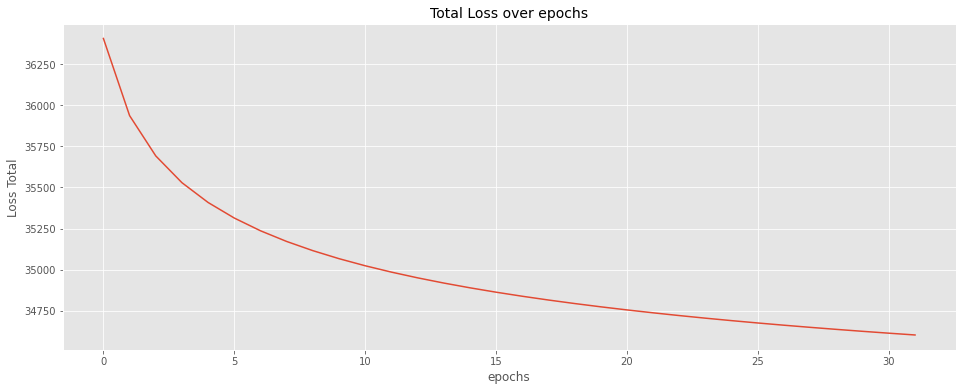

In [57]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


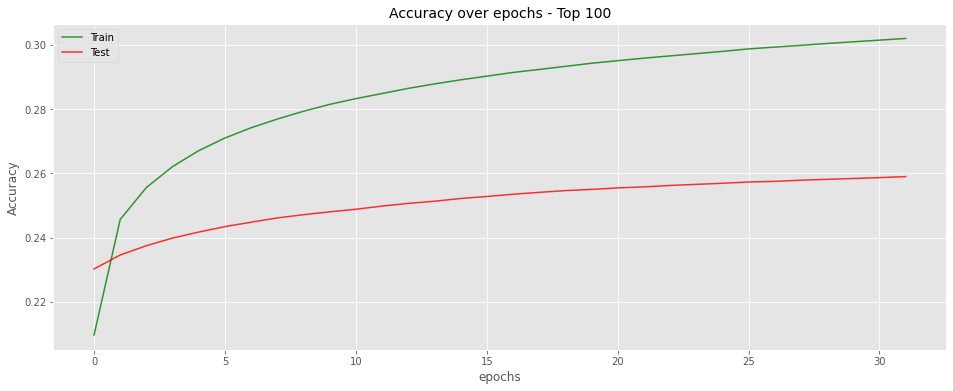

In [60]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_4.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs - Top 100", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

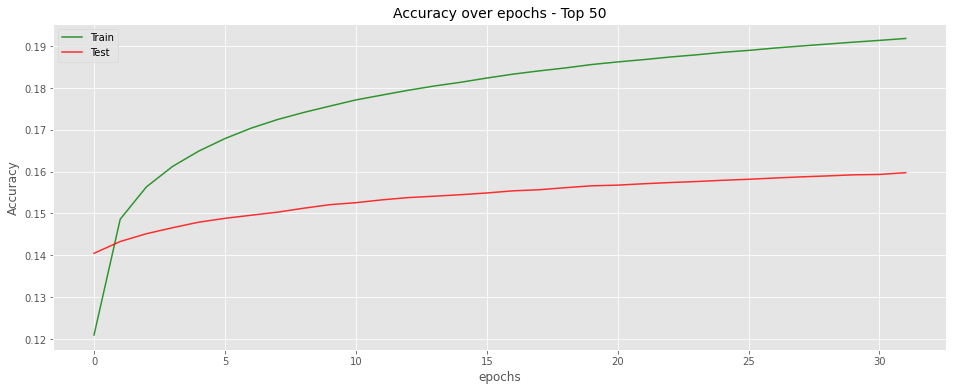

In [61]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['factorized_top_k/top_50_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_4.history['val_factorized_top_k/top_50_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs - Top 50", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

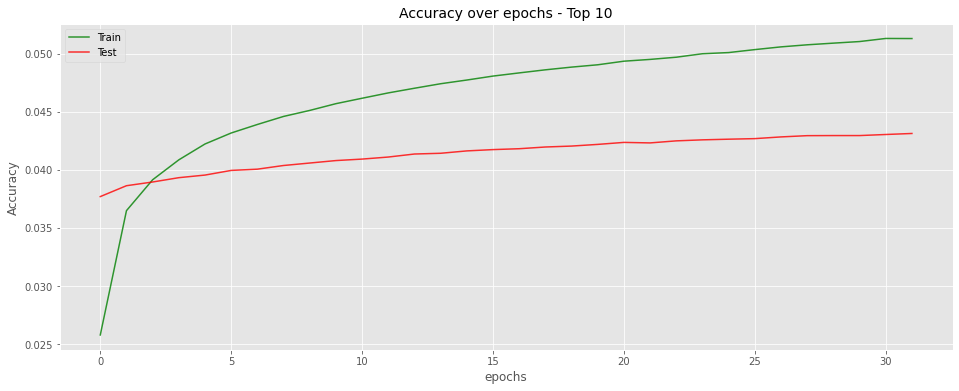

In [62]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['factorized_top_k/top_10_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_4.history['val_factorized_top_k/top_10_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs - Top 10", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [59]:
#Evaluate the Base model
model_4.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 30s 242ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy: 0.0222 - factorized_top_k/top_10_categorical_accuracy: 0.0431 - factorized_top_k/top_50_categorical_accuracy: 0.1597 - factorized_top_k/top_100_categorical_accuracy: 0.2590 - loss: 13571.5660 - regularization_loss: 0.0000e+00 - total_loss: 13571.5660


{'factorized_top_k/top_1_categorical_accuracy': 0.003347303718328476,
 'factorized_top_k/top_5_categorical_accuracy': 0.022155391052365303,
 'factorized_top_k/top_10_categorical_accuracy': 0.04312703013420105,
 'factorized_top_k/top_50_categorical_accuracy': 0.15974277257919312,
 'factorized_top_k/top_100_categorical_accuracy': 0.2589661478996277,
 'loss': 846.0517578125,
 'regularization_loss': 0,
 'total_loss': 846.0517578125}

## 5. Tuning Summary

As we can see below, we managed to improve accuracy and reduce loss by: 

 1. Increase embedding_dimension from 32-> 64
 2. keeping learning_rate 0.1

As a result, loss was reduced from 903.56 (Baseline) to 846.05 and top_10_accuracy was improved from 3.2% to 4.3%.

| Tuning | top_1_accuracy |top_5_accuracy | top_10_accuracy | top_50_accuracy | top_100_accuracy|loss|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:
|**Baseline Model:** embedding_dimension 32 -> 64, learning_rate 0.1, epochs=5 | 0.002739|0.016660|0.032353|0.125389|0.207780|903.56|
|**Model_1:** embedding_dimension 32 -> 64, learning_rate 0.1 , epochs=5|0.002999|0.020739|0.039571|0.143078|0.231983|874.51|
|**Model_2:** embedding_dimension 64, learning_rate 0.01, epochs=5|0.003095 | 0.021155|0.040475 |0.145901 | 0.235966|868.06|
|**Model_3:** embedding_dimension 64, learning_rate 0.001, epochs=5|0.002995| 0.021155| 0.040491 | 0.145969| 0.236346|867.46|
|**Model_4:** embedding_dimension 64, learning_rate 0.1, epochs=32|0.003347|  0.022155| 0.043127 | 0.159742| 0.258966|846.05|

## 5. Making predictions

Now that we have a final model (Model_4), we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [65]:
# Recommend the 5 best movies for user 42:

# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model_4.user_model)

# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model_4.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :5]}")

Recommendations for user 42: [b'Rocketship X-M (1950)' b'7th Voyage of Sinbad, The (1958)'
 b'Earth Vs. the Flying Saucers (1956)' b'Dreamscape (1984)'
 b'2010 (1984)']


## 6. Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

 * a serving query model, taking in features of the query and transforming them into a query embedding, and
 * a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.
 
In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a SavedModel format, which makes it possible to serve using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

To deploy a model like this, we simply export the BruteForce layer we created above:

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

  # Save the index.
    index.save(path)

  # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.keras.models.load_model(path)

  # Pass a user id in, get top predicted movie titles back.
    scores, titles = loaded(["42"])
    
    print(f"Recommendations: {titles[0][:5]}")

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))